### Load the Data

upload a spectrogram data set with file structure 

spec/positive
spec/negative

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # Used to unzip a data set loaded to the drive
import zipfile

with zipfile.ZipFile("/content/drive/MyDrive/MotifGAN Capstone/spec_solo_stretch_dist_noise_2.zip") as z:
  z.extractall()

In [ ]:
import os
os.mkdir("spec")
os.rename("negative", "spec/negative")
os.rename("positive", "spec/positive")

positives_ec5496bd5d6345c65930d307ec311f62.mp3_copy.wav_distorted_1.mp3_copy.png
negatives_6815279e02d5ae66e9994043faa5ceb3.mp3_copy.wav_distorted_1.mp3_noisy_1.png


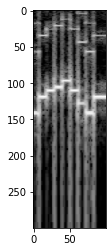

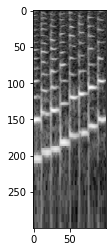

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pos_img_name = random.choice(os.listdir('./spec/positive'))
neg_img_name = random.choice(os.listdir('./spec/negative'))

print(pos_img_name)
pos_img = mpimg.imread(f'./spec/positive/{pos_img_name}')
plt.figure()
plt.imshow(pos_img)
print(neg_img_name)
neg_img = mpimg.imread(f'./spec/negative/{neg_img_name}')
plt.figure()
plt.imshow(neg_img)

### create the dataset

In [ ]:
import tensorflow as tf

In [ ]:
# randomly set aside some examples for validation

os.makedirs("val/positive")
os.makedirs("val/negative")

for category in os.listdir("spec"):
  for f in os.listdir(f"spec/{category}"):
    if random.uniform(0,1) < 0.2:
      os.rename(f"spec/{category}/{f}", f"val/{category}/{f}")

In [ ]:
# Load dataset from directory with keras

# sometimes a directory called .ipynb_checkpoints is present, remove it if so
if os.path.isdir('./spec/.ipynb_checkpoints'):
  os.removedirs("./spec/.ipynb_checkpoints")

train_dir = './spec/'
val_dir = './val'
BATCH_SIZE = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE, 
    image_size=(100,300),
    seed=123
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE, 
    image_size=(100,300),
    seed=123
)

class_names = train_ds.class_names
print(class_names)

Found 18664 files belonging to 2 classes.
Found 4610 files belonging to 2 classes.
['negative', 'positive']


## ResNet-34 Model

In [ ]:
from tensorflow import keras

In [ ]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides,
                            padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1,
                            padding="same", use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides,
                                  padding="same", use_bias=False),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 5, strides=2, input_shape=[100, 300, 3],
                              padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filter = 64
for filters in [64]*3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filter else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
#model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(2, activation="softmax"))

In [ ]:
learning_rate = 0.01

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam(learning_rate)
metrics = ['acc']
model.compile(optimizer, loss_fn, metrics)
#model.summary()

In [ ]:
# Set the epochs
epochs = 10
print('\nFitting:')

# Train the model.
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=BATCH_SIZE)


Fitting:
Epoch 1/10
292/292 [==============================] - 64s 169ms/step - loss: 0.7152 - acc: 0.6589 - val_loss: 1.1625 - val_acc: 0.5651
Epoch 2/10
292/292 [==============================] - 48s 162ms/step - loss: 0.4852 - acc: 0.7741 - val_loss: 0.6621 - val_acc: 0.7486
Epoch 3/10
292/292 [==============================] - 48s 163ms/step - loss: 0.3619 - acc: 0.8392 - val_loss: 0.8681 - val_acc: 0.7790
Epoch 4/10
292/292 [==============================] - 48s 163ms/step - loss: 0.2216 - acc: 0.9085 - val_loss: 0.6734 - val_acc: 0.7705
Epoch 5/10
292/292 [==============================] - 48s 163ms/step - loss: 0.1247 - acc: 0.9516 - val_loss: 0.2430 - val_acc: 0.9245
Epoch 6/10
292/292 [==============================] - 48s 163ms/step - loss: 0.0735 - acc: 0.9733 - val_loss: 0.2954 - val_acc: 0.9108
Epoch 7/10
292/292 [==============================] - 48s 162ms/step - loss: 0.0789 - acc: 0.9732 - val_loss: 0.0939 - val_acc: 0.9709
Epoch 8/10
292/292 [=========================

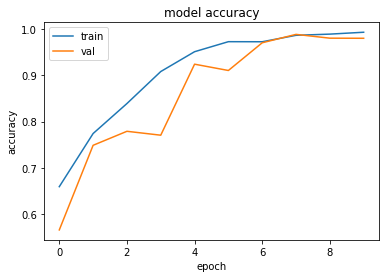

In [ ]:
# print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model_name = f"motifcnn_862_3_{epochs}ep_{learning_rate}lr.tf"
model.save(model_name)
model_name

INFO:tensorflow:Assets written to: motifcnn_862_2_10ep_0.01lr.tf/assets


INFO:tensorflow:Assets written to: motifcnn_862_2_10ep_0.01lr.tf/assets


'motifcnn_862_2_10ep_0.01lr.tf'

In [ ]:
import shutil
shutil.make_archive(model_name, "zip", model_name)

'/content/motifcnn_862_2_10ep_0.01lr.tf.zip'

In [ ]:
!cp -r "motifcnn_862_2_10ep_0.01lr.tf.zip" "drive/MyDrive/MotifGAN Capstone/motifcnn_862_2_10ep_0.01lr.tf.zip"